In [ ]:
tf_version = !pip3 show tensorflow | grep Version
if '2.2' not in tf_version[0]:
  print("downgrading tensorflow")
  !pip3 uninstall --yes tensorflow
  !pip3 install tensorflow==2.2
tf_version = !pip3 show tensorflow | grep Version
print("current tensorflow " + tf_version[0])

keras_version = !pip3 show keras | grep Version
if '2.3.1' not in keras_version[0]:
  print("downgrading keras")
  !pip3 uninstall --yes keras
  !pip3 install keras==2.3.1
keras_version = !pip3 show keras | grep Version

print("current keras " + keras_version[0])

current tensorflow Version: 2.2.0
current keras Version: 2.3.1


In [ ]:
import pickle

from keras.optimizers import Adam, RMSprop
from keras import Input, layers
from keras.models import Model, load_model
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
                         
from keras.layers.merge import add
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np

basedir ='/content/drive/MyDrive/MB/'

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
# Loading Image Features
train_features = pickle.load(open(basedir + "encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

test_features = pickle.load(open(basedir + "encoded_test_images.pkl", "rb"))
print('Photos: test=%d' % len(test_features))

# Loading wordtoix
wordtoix = pickle.load(open(basedir + "PL_wordtoix.pkl", "rb"))
print('Wordtoix Length = %d' % len(wordtoix))

# Loading embedding_matrix
embedding_matrix = pickle.load(open(basedir + "PL_Embedding_Matrix.pkl", "rb"))
print('Embedding Matrix shape = (%d, %d)' % (embedding_matrix.shape))

# Loading all translated descriptions
all_descriptions = pickle.load(open("/content/drive/MyDrive/MB/PL_clean_translated_descriptions.pkl", "rb"))
print('Translated descriptions: all=%d' % len(all_descriptions))

all_raw_descriptions = pickle.load(open("/content/drive/MyDrive/Translations/translated_descriptions.pkl", "rb"))
print('Raw translated descriptions: all=%d' % len(all_raw_descriptions))

Photos: train=6000
Photos: test=1000
Wordtoix Length = 20140
Embedding Matrix shape = (20140, 300)
Translated descriptions: all=8092
Raw translated descriptions: all=8092


In [ ]:
all_descriptions_tagged = {k: ['startseq ' + d.lower() + ' endseq' for d in v] for k, v in all_descriptions.items()}
ixtoword = {v: k for k, v in wordtoix.items()}

train_keys = [k.split('.')[0] for k in train_features.keys()]
test_keys = [k.split('.')[0] for k in test_features.keys()]

train_descriptions = {k: all_descriptions_tagged[k] for k in train_keys}
test_descriptions = {k: all_descriptions_tagged[k] for k in test_keys}

In [ ]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[np.array(X1), np.array(X2)], np.array(y)]
                X1, X2, y = list(), list(), list()
                n=0
    return X1, X2, y

In [ ]:
max_length = 35 
vocab_size = embedding_matrix.shape[0]
embedding_dim = embedding_matrix.shape[1]

In [ ]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False
print(model.summary())
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001))

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 35, 300)      6042000     input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_1[0][0]                    
____________________________________________________________________________________________

In [ ]:
# model = load_model(basedir + 'model_pl_raw_14.h5')
start_epoch = 0
epochs = 40
number_pics_per_bath = 6
steps = len(train_descriptions)//number_pics_per_bath

for i in range(start_epoch, start_epoch + epochs):
    print('epoch: %d' % i)
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    # model.save(basedir + 'model_pl_raw_' + str(i) + '.h5')

model.save(basedir + 'model_pl.h5')

epoch: 0
Epoch 1/1
1000/1000 [==============================] - 102s 102ms/step - loss: 4.7236
epoch: 1
Epoch 1/1
1000/1000 [==============================] - 102s 102ms/step - loss: 4.0155
epoch: 2
Epoch 1/1
1000/1000 [==============================] - 102s 102ms/step - loss: 3.7563
epoch: 3
Epoch 1/1
1000/1000 [==============================] - 100s 100ms/step - loss: 3.5681
epoch: 4
Epoch 1/1
1000/1000 [==============================] - 101s 101ms/step - loss: 3.4234
epoch: 5
Epoch 1/1
1000/1000 [==============================] - 100s 100ms/step - loss: 3.3024
epoch: 6
Epoch 1/1
1000/1000 [==============================] - 99s 99ms/step - loss: 3.2034
epoch: 7
Epoch 1/1
1000/1000 [==============================] - 99s 99ms/step - loss: 3.1179
epoch: 8
Epoch 1/1
1000/1000 [==============================] - 99s 99ms/step - loss: 3.0450
epoch: 9
Epoch 1/1
1000/1000 [==============================] - 100s 100ms/step - loss: 2.9879
epoch: 10
Epoch 1/1
1000/1000 [=========================

In [ ]:
def greedySearch(photo, model):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

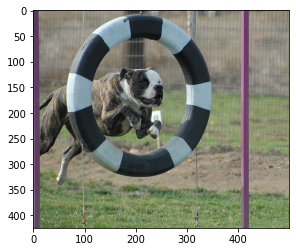

Model na danych oczyszczonych:
Greedy: czarny biały pies biec trawa
Refs: 
 czarny biały pies skakać czarny biały obręcz
czarny biały pies przeskakiwać czarny biały obręcz
brązowy biały pies przeskakiwać czarny biały obręcz
pies przeskakiwać czarny biały obręcz
pies skakać pierścień



Model na danych nieoczyszczonych:
Greedy: border collie łapie przez czarno-białą obręcz
Refs: 
 Czarno-biały pies skacze przez czarno-białą obręcz
Czarno-biały pies przeskakuje przez czarno-białą obręcz
Brązowy i biały pies przeskakuje przez czarno-białą obręcz
Pies przeskakuje przez czarno-białą obręcz
Pies skaczący przez pierścień


In [ ]:
directory_path = '/content/drive/My Drive/Flickr8k_Dataset/Flicker8k_Dataset/'

z = 31

pic = list(train_features.keys())[z]
# pic = list(encoding_test.keys())[z]
image = train_features[pic].reshape((1,2048))
x=plt.imread(directory_path+pic)
plt.imshow(x)
plt.show()

model = load_model(basedir + 'model_pl.h5')
print("Model na danych oczyszczonych:")
result = greedySearch(image, model)
print("Greedy:", result)
print("Refs: \n", '\n'.join(all_descriptions[pic.split('.')[0]]))

print("\n\n")
model_raw = load_model(basedir + 'model_pl_raw.h5')
print("Model na danych nieoczyszczonych:")
result_raw = greedySearch(image, model_raw)
print("Greedy:", result_raw)
print("Refs: \n", '\n'.join(all_raw_descriptions[pic.split('.')[0]]))

In [ ]:
from tqdm.notebook import tqdm

pl_train_predictions = {img_id: greedySearch(img_features.reshape((1, 2048)), model) for img_id, img_features in tqdm(train_features.items())}
pickle.dump(pl_train_predictions, open(basedir + 'pl_train_predictions.pkl', 'wb'))

pl_train_raw_predictions = {img_id: greedySearch(img_features.reshape((1, 2048)), model_raw) for img_id, img_features in tqdm(train_features.items())}
pickle.dump(pl_train_raw_predictions, open(basedir + 'pl_train_raw_predictions.pkl', 'wb'))

pl_test_predictions = {img_id: greedySearch(img_features.reshape((1, 2048)), model) for img_id, img_features in tqdm(test_features.items())}
pickle.dump(pl_test_predictions, open(basedir + 'pl_test_predictions.pkl', 'wb'))

pl_test_raw_predictions = {img_id: greedySearch(img_features.reshape((1, 2048)), model_raw) for img_id, img_features in tqdm(test_features.items())}
pickle.dump(pl_test_raw_predictions, open(basedir + 'pl_test_raw_predictions.pkl', 'wb'))
